### Base settings

In [28]:
%load_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
from pprint import pprint
from pathlib import Path
import pandas as pd
from collections import OrderedDict

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10-ood_8.yaml'
# config_path = Path('configs') / 'custom_vit_tiny-scratch-cifar10-ood_8.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name
checkpoint_path = log_root / 'checkpoints'

In [6]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

if config.model.pretrained:
    n_class = len(config.dataset.in_distribution_class_indices)
    model = torch.hub.load(
        repo_or_dir=config.model.repo,
        model=config.model.pretrained_model,
        pretrained=False,
    )
    model.head = nn.Linear(model.head.in_features, n_class)
else:
    model = ViT(
        image_size=config.model.img_size,
        patch_size=config.model.patch_size,
        num_classes=len(config.dataset.in_distribution_class_indices),
        dim=config.model.dim_head,
        depth=config.model.depth,
        heads=config.model.n_heads,
        mlp_dim=config.model.dim_mlp,
        dropout=config.model.dropout,
        emb_dropout=config.model.emb_dropout,
        visualize=True,
    )

model = model.to(device=device)
print(model)

checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

state_dict = checkpoint['model_state_dict']
trimmed_keys = []
for key in state_dict.keys():
    # remove prefix 'module.' for each key (in case of DataParallel)
    trimmed_keys.append(key[7:])
trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

model.load_state_dict(trimmed_state_dict)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

<All keys matched successfully>

In [11]:
from ood_with_vit.datasets import OOD_CIFAR10

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size
in_distribution_class_indices = config.dataset.in_distribution_class_indices

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

dataset = OOD_CIFAR10(
    root=dataset_root, 
    in_distribution_class_indices=in_distribution_class_indices, 
    train=False, 
    download=False, 
    transform=transform_test
)
testloader = DataLoader(
    dataset=dataset,
    batch_size=config.eval.batch_size,
    shuffle=False,
    num_workers=8,
)

class_indices = list(range(len(dataset.classes)))
ood_class_indices = [i for i in class_indices if i not in in_distribution_class_indices]
in_class_indices = [i for i in class_indices if i in in_distribution_class_indices]
print(dataset.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


### Utility functions

In [8]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Visualize attention maps

In [66]:
from ood_with_vit.visualizer import ViTAttentionRollout
from ood_with_vit.utils import (
    compute_attention_maps,
    compute_logits,
)

def visualize_results(
    original_img, 
    attn_weights, 
    head_fusion='max',
    discard_ratio=0.9,
):
    visualizer = ViTAttentionRollout(
        head_fusion=head_fusion,
        discard_ratio=discard_ratio
    )
    mask = visualizer.rollout(attn_weights)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)

    plt.subplot(1, 3, 2)
    visualized_img = visualizer.get_visualized_masks(original_img, mask)
    visualized_img = visualized_img[:, :, ::-1]
    plt.imshow(visualized_img)

    plt.subplot(1, 3, 3)
    plt.imshow(mask)
    cax = fig.add_axes([
        ax.get_position().x1 + 0.01,
        ax.get_position().y0 + ax.get_position().height * 0.2, 
        0.02,
        ax.get_position().height * 0.6
    ])
    plt.colorbar(cax=cax)

    plt.show()
    
    return mask

#### Test in-distribution samples

100%|██████████| 90/90 [00:35<00:00,  2.56it/s]


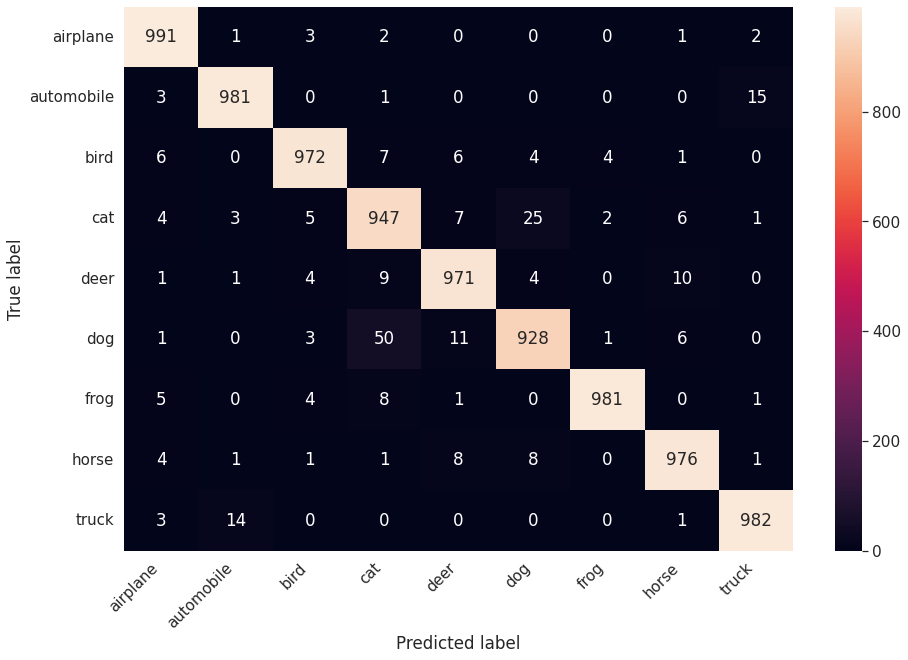

{'airplane': 0.991,
 'automobile': 0.981,
 'bird': 0.972,
 'cat': 0.947,
 'deer': 0.971,
 'dog': 0.928,
 'frog': 0.981,
 'horse': 0.976,
 'truck': 0.982}
mean acc: 0.9699


In [46]:
# calculate in-distribution data statistics
import plotly.figure_factory as ff
import seaborn as sn

n_class = len(config.dataset.in_distribution_class_indices)
confusion_matrix = np.zeros((n_class, n_class))
accuracy = {}
model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader):
        x, y = x.to(device), y.to(device)
        logits = compute_logits(config, model, x)
        _, preds = logits.max(1)
        for label, pred in zip(y.view(-1), preds.view(-1)):
            label, pred = int(label.item()), int(pred.item())
            confusion_matrix[label, pred] += 1 

in_dist_classes = [dataset.classes[i] for i in in_class_indices]
df_cm = pd.DataFrame(confusion_matrix, in_dist_classes, in_dist_classes)
plt.figure(figsize=(15, 10))
heatmap = sn.heatmap(df_cm, annot=True, fmt='g')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.close()

accuracy = confusion_matrix.diagonal() / confusion_matrix.sum(axis=1)
mean_acc = accuracy.mean()
accuracy = {dataset.classes[idx]: accuracy[i] for i, idx in enumerate(in_class_indices)}

pprint(accuracy)
print(f'mean acc: {mean_acc:.4f}')

max logit: 10.042536735534668
max class: cat
logit: [[-1.7942 -1.001  -1.958  10.0425 -4.3302  0.0008 -1.9898 -2.8893 -0.8253]]
attn weights: 12 torch.Size([1, 3, 197, 197])


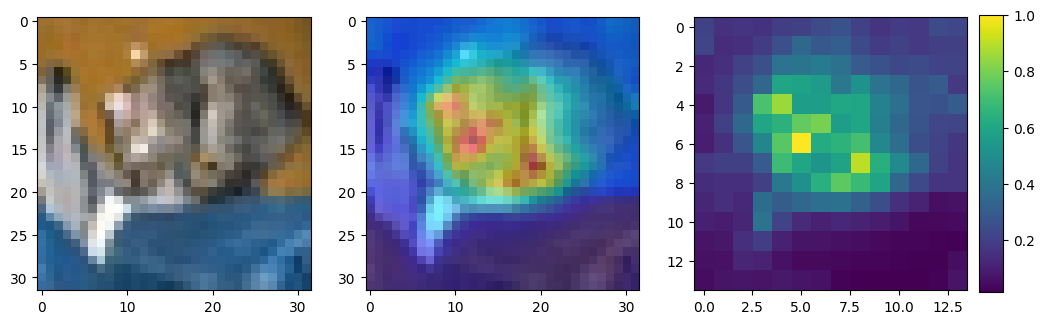

In [52]:
# visualize in-distribution class attention maps.
plt.rcdefaults()
np.set_printoptions(suppress=True, precision=4)
id_class_name = 'cat' 
id_class_idx, img_idx = dataset.class_to_idx[id_class_name], 0
original_img = dataset.img_dict[id_class_idx][img_idx]

test_img = dataset.get_transformed_image(id_class_idx, img_idx)
test_img = test_img.to(device=device)
attention_maps = compute_attention_maps(config, model, test_img.unsqueeze(0))
logits = compute_logits(config, model, test_img.unsqueeze(0))
# logit, attn_weights = model(test_img.unsqueeze(0))
max_logit, max_class = logits.max(1)
print('max logit:', max_logit.item())
print('max class:', dataset.classes[dataset.idx_to_id_class[max_class.item()]])
print('logit:', logits.numpy())
print('attn weights:', len(attention_maps), attention_maps[0].shape)

visualize_results(
    original_img, 
    attention_maps, 
    head_fusion='max',
    discard_ratio=0.90,
)

#### Test out-of-distribution samples

In [58]:
# calculate out-of-distribution data statistics
ood_class_name = 'ship'
ood_class_idx = dataset.class_to_idx[ood_class_name]
counts = {dataset.classes[idx]: 0 for idx in in_class_indices}
for i in tqdm(range(len(dataset.img_dict[ood_class_idx]))):
    test_img = dataset.get_transformed_image(ood_class_idx, i)
    test_img = test_img.to(device=device)
    logits = compute_logits(config, model, test_img.unsqueeze(0))
    _, max_class = logits.max(1)
    max_class = dataset.classes[dataset.idx_to_id_class[max_class.item()]]
    counts[max_class] += 1
    
for class_name, count in counts.items():
    ratio = count / len(dataset.img_dict[ood_class_idx])
    counts[class_name] = (count, ratio)
pprint(counts)

100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]

{'airplane': (765, 0.765),
 'automobile': (77, 0.077),
 'bird': (13, 0.013),
 'cat': (4, 0.004),
 'deer': (4, 0.004),
 'dog': (2, 0.002),
 'frog': (13, 0.013),
 'horse': (3, 0.003),
 'truck': (119, 0.119)}


max logit: 8.236295700073242
max class: automobile
logit: [[ 6.0888  8.2363 -1.9129 -1.339  -3.3908 -1.3641 -1.4866 -2.2513 -0.0522]]
attn weights: 12 torch.Size([1, 3, 197, 197])


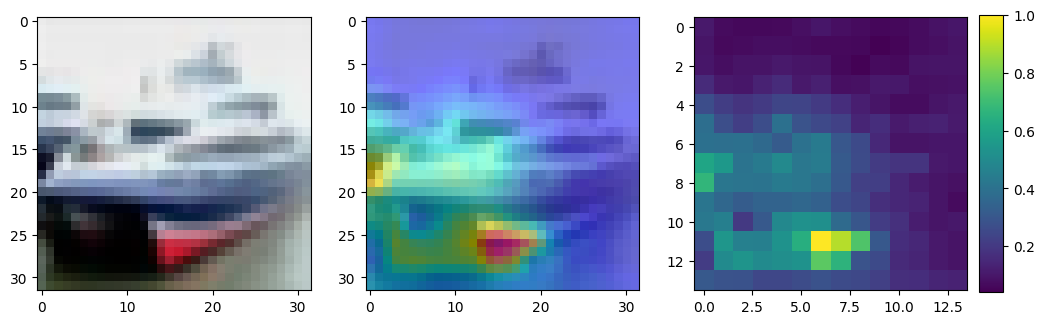

In [73]:
# visualize out-of-distribution class attention maps.  
ood_class_name = 'ship'
ood_class_idx, img_idx = dataset.class_to_idx[ood_class_name], 0
original_img = dataset.img_dict[ood_class_idx][img_idx]

test_img = dataset.get_transformed_image(ood_class_idx, img_idx)
test_img = test_img.to(device=device)
attention_maps = compute_attention_maps(config, model, test_img.unsqueeze(0))
logits = compute_logits(config, model, test_img.unsqueeze(0))
max_logit, max_class = logits.max(1)
print('max logit:', max_logit.item())
print('max class:', dataset.classes[dataset.idx_to_id_class[max_class.item()]])
print('logit:', logits.numpy())
print('attn weights:', len(attention_maps), attention_maps[0].shape)

mask = visualize_results(
    original_img, 
    attention_maps, 
    head_fusion='max',
    discard_ratio=0.90,
)

In [74]:
# mask analysis
print(type(mask))
print('mask norm:', np.linalg.norm(mask))

<class 'numpy.ndarray'>
mask norm: 4.0936913
